MH

Train neural network models (at least two different networks for each dataset, i.e., no. layers, no. neurons, activation, ...) in either Tensorflow or Pytorch to perform classification on the following datasets:

Cifar-10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
 
import numpy as np
import PIL
import matplotlib.pyplot as mtplt
 
print("imported!")

imported!


Import data:

In [2]:
 classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Download and extract the data:

In [3]:
 torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
 !

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data


Create a dataset with manual import using pickle's unpickle:

In [4]:
from PIL import Image
import os
import os.path
import numpy as np
import pickle
from typing import Any, Callable, Optional, Tuple
 
class CIFAR10(torchvision.datasets.vision.VisionDataset):
    base_folder = 'cifar-10'
    train_list = [
        'data_batch_1',
        'data_batch_2',
        'data_batch_3',
        'data_batch_4',
        'data_batch_5',
    ]
 
    test_list = [
        'test_batch',
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names'
    }
 
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None
    ) -> None:
 
        super(CIFAR10, self).__init__(root, transform=transform,
                                      target_transform=target_transform)
 
        self.train = train  # training set or test set
 
        if self.train:
            the_list = self.train_list
        else:
            the_list = self.test_list
 
        self.data: Any = []
        self.targets = []
 
        # now load the picked numpy arrays
        for file_name in the_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            import pickle
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
 
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC
 
        self._load_meta()
 
    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        import pickle
        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}
 
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
 
        if self.transform is not None:
            img = self.transform(img)
 
        if self.target_transform is not None:
            target = self.target_transform(target)
 
        return img, target
 
    def __len__(self) -> int:
        return len(self.data)
 
    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

Load training and test set and loaders using the previous custom dataset, then applying a normalization transform with mean and std of 0.5 for 3 channels:

In [5]:
transf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
train_set = CIFAR10(root='./data', train=True, transform=transf)
test_set = CIFAR10(root='./data', train=False, transform=transf)
 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=0)

Define two networks, one using a simple multi-layer fully-connected network and one using convolutional layers (CNN):

In [6]:
import torch.nn as nn
import torch.nn.functional as F
 
 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
 
net = Net()

In [7]:
import torch.nn.functional as F
 
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(3*32*32, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 10)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
net2 = Net2()

Define a Loss function and optimizer

In [8]:
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
 import torch.optim as optim
 
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=0.0015, momentum=0.8)

Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# Assuming that we are on a CUDA machine, this should print a CUDA device:
 
print(device)

cuda:0


In [11]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)

In [12]:
from torch.autograd import Variable
 
epochs=2
 
# for later visualiztions:
loss_list = []
iteration_list = []
accuracy_list = []
 
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data[0].to(device), data[1].to(device)
 
        # zero the parameter gradients
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        
        # Testing the model
        if not (i % 500):
            total = 0
            correct = 0
        
            for images, label in test_loader:
                images, label = images.to(device), label.to(device)
            
                test = Variable(images.view(4, 3, 32, 32))
            
                output = net(test)
            
                predictions = torch.max(output, 1)[1].to(device)
                correct += (predictions == label).sum()
            
                total += len(label)
            
            accuracy = (correct * 100) // total
            loss_list.append(loss.data)
            iteration_list.append(i)
            accuracy_list.append(accuracy)
 
        # print statistics
        running_loss += loss.item()
        if not (i % 1000):    # print every 1000 mini-batches
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
            print("Epoch: {}, Step: {}, Loss: {}, Accuracy: {}%"
              .format(epoch + 1, i, loss.data, accuracy)
            )
            
print('Finished Training')

[1,     1] loss: 0.023
Epoch: 1, Step: 0, Loss: 2.3348608016967773, Accuracy: 10%
[1,  1001] loss: 22.984
Epoch: 1, Step: 1000, Loss: 2.250182628631592, Accuracy: 16%
[1,  2001] loss: 21.363
Epoch: 1, Step: 2000, Loss: 2.1127333641052246, Accuracy: 27%
[1,  3001] loss: 19.474
Epoch: 1, Step: 3000, Loss: 1.8684124946594238, Accuracy: 32%
[1,  4001] loss: 17.970
Epoch: 1, Step: 4000, Loss: 2.2419440746307373, Accuracy: 35%
[1,  5001] loss: 17.013
Epoch: 1, Step: 5000, Loss: 1.1781201362609863, Accuracy: 35%
[1,  6001] loss: 16.297
Epoch: 1, Step: 6000, Loss: 2.2220072746276855, Accuracy: 41%
[1,  7001] loss: 15.952
Epoch: 1, Step: 7000, Loss: 0.9993030428886414, Accuracy: 42%
[1,  8001] loss: 15.507
Epoch: 1, Step: 8000, Loss: 1.455379605293274, Accuracy: 43%
[1,  9001] loss: 15.331
Epoch: 1, Step: 9000, Loss: 0.8877333402633667, Accuracy: 46%
[1, 10001] loss: 15.076
Epoch: 1, Step: 10000, Loss: 1.8396695852279663, Accuracy: 45%
[1, 11001] loss: 15.130
Epoch: 1, Step: 11000, Loss: 1.6377

In [13]:
 
from torch.autograd import Variable
 
net2.to(device)
 
epochs=2
 
# for later visualiztions:
loss_list2 = []
iteration_list2 = []
accuracy_list2 = []
 
 
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data[0].to(device), data[1].to(device)
 
        # zero the parameter gradients
        optimizer2.zero_grad()
 
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
 
        
        # Testing the model
        if not (i % 500):
            total = 0
            correct = 0
        
            for images, label in test_loader:
                images, label = images.to(device), label.to(device)
            
                test = Variable(images.view(4, 3, 32, 32))
            
                output = net2(test)
            
                predictions = torch.max(output, 1)[1].to(device)
                correct += (predictions == label).sum()
            
                total += len(label)
            
            accuracy = (correct * 100) // total
            loss_list2.append(loss.data)
            iteration_list2.append(i)
            accuracy_list2.append(accuracy)
 
        # print statistics
        running_loss += loss.item()
        if not (i % 1000):    # print every 1000 mini-batches
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
            print("Epoch: {}, Step: {}, Loss: {}, Accuracy: {}%"
              .format(epoch + 1, i, loss.data, accuracy)
            )
            
print('Finished Training')

[1,     1] loss: 0.024
Epoch: 1, Step: 0, Loss: 2.370211124420166, Accuracy: 10%
[1,  1001] loss: 22.987
Epoch: 1, Step: 1000, Loss: 2.3283238410949707, Accuracy: 15%
[1,  2001] loss: 22.485
Epoch: 1, Step: 2000, Loss: 2.394868850708008, Accuracy: 21%
[1,  3001] loss: 20.699
Epoch: 1, Step: 3000, Loss: 1.6252655982971191, Accuracy: 27%
[1,  4001] loss: 19.362
Epoch: 1, Step: 4000, Loss: 1.865368366241455, Accuracy: 33%
[1,  5001] loss: 18.350
Epoch: 1, Step: 5000, Loss: 1.364591360092163, Accuracy: 36%
[1,  6001] loss: 17.582
Epoch: 1, Step: 6000, Loss: 2.0765206813812256, Accuracy: 35%
[1,  7001] loss: 17.511
Epoch: 1, Step: 7000, Loss: 1.5749340057373047, Accuracy: 37%
[1,  8001] loss: 16.734
Epoch: 1, Step: 8000, Loss: 1.7822020053863525, Accuracy: 40%
[1,  9001] loss: 16.508
Epoch: 1, Step: 9000, Loss: 1.9733271598815918, Accuracy: 41%
[1, 10001] loss: 16.486
Epoch: 1, Step: 10000, Loss: 1.1599520444869995, Accuracy: 42%
[1, 11001] loss: 16.245
Epoch: 1, Step: 11000, Loss: 1.441493

Let's save our models:

In [14]:
path1 = './cifar1.pth'
path2 = './cifar2.pth'
torch.save(net.state_dict(), path1)
torch.save(net2.state_dict(), path2)

 Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the real values. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

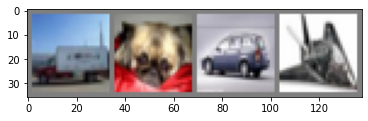

truck   dog   car plane


In [15]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    mtplt.imshow(np.transpose(npimg, (1, 2, 0)))
    mtplt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Test Network_1 (CNN):

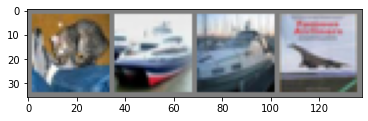

Real values:    cat  ship  ship plane


In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Real values: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


The second net (simple fully connected):

In [19]:
outputs2 = net2(images.to(device))
_, predicted2 = torch.max(outputs2, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


Hmmm. the second image do look like a car or truck..

Let's do some evaluations:

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


And for the second net:

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

CNN:

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 73 %
Accuracy of  bird : 39 %
Accuracy of   cat : 40 %
Accuracy of  deer : 50 %
Accuracy of   dog : 24 %
Accuracy of  frog : 61 %
Accuracy of horse : 69 %
Accuracy of  ship : 75 %
Accuracy of truck : 56 %


Fully-Connected:

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 67 %
Accuracy of  bird : 30 %
Accuracy of   cat : 37 %
Accuracy of  deer : 46 %
Accuracy of   dog : 30 %
Accuracy of  frog : 55 %
Accuracy of horse : 58 %
Accuracy of  ship : 66 %
Accuracy of truck : 47 %


Let's do the visualiztions I promised you:

There is line which the diagram, which goes back and starts from the begining. It's the point the network went to the second epoch.

CNN:

49

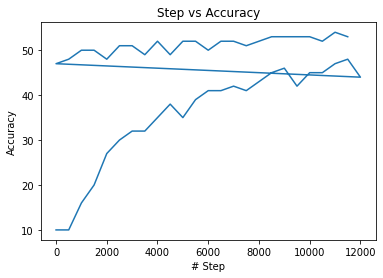

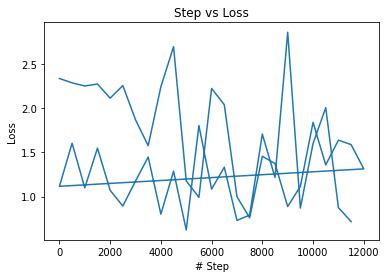

In [31]:
mtplt.plot(iteration_list[0:int(len(iteration_list)/2)-1], accuracy_list[0:int(len(iteration_list)/2)-1])
mtplt.xlabel("# Step")
mtplt.ylabel("Accuracy")
mtplt.title("Step vs Accuracy")
mtplt.show()

mtplt.plot(iteration_list[0:int(len(iteration_list)/2)-1], loss_list[0:int(len(iteration_list)/2)-1])
mtplt.xlabel("# Step")
mtplt.ylabel("Loss")
mtplt.title("Step vs Loss")
mtplt.show()

FC:

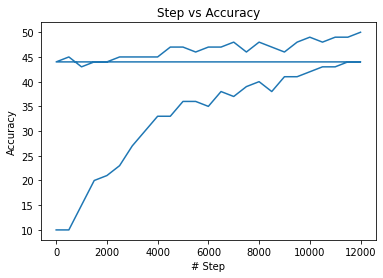

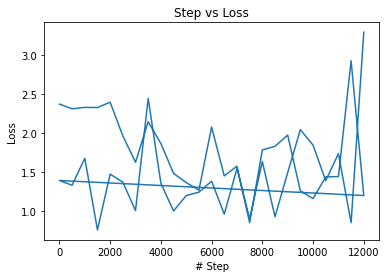

In [32]:
mtplt.plot(iteration_list2, accuracy_list2)
mtplt.xlabel("# Step")
mtplt.ylabel("Accuracy")
mtplt.title("Step vs Accuracy")
mtplt.show()

mtplt.plot(iteration_list2, loss_list2)
mtplt.xlabel("# Step")
mtplt.ylabel("Loss")
mtplt.title("Step vs Loss")
mtplt.show()